In [1]:

### Required libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns
import cv2
# from osgeo import gdal
import colorsys
from PIL import Image
from scipy import misc
from skimage import io
from spectral import get_rgb
from spectral import ndvi
from sklearn import preprocessing


In [2]:
train_path1='train_jpg'
train_path2='train_tif/'
test_path1='test_jpg'
print(test_path1)

test_jpg


                                                 label  count
2                                        clear primary  13636
11                               partly_cloudy primary   3630
10                                              cloudy   2089
9                                  clear primary water   1850
12                      agriculture clear primary road   1680
18                           agriculture clear primary   1626
0                                         haze primary   1471
6                agriculture clear cultivation primary   1170
3            agriculture clear habitation primary road   1125
1                      agriculture clear primary water    712
34                   agriculture partly_cloudy primary    692
30                         partly_cloudy primary water    595
26              agriculture partly_cloudy primary road    527
13                            clear primary road water    504
16                           clear cultivation primary    472
27      

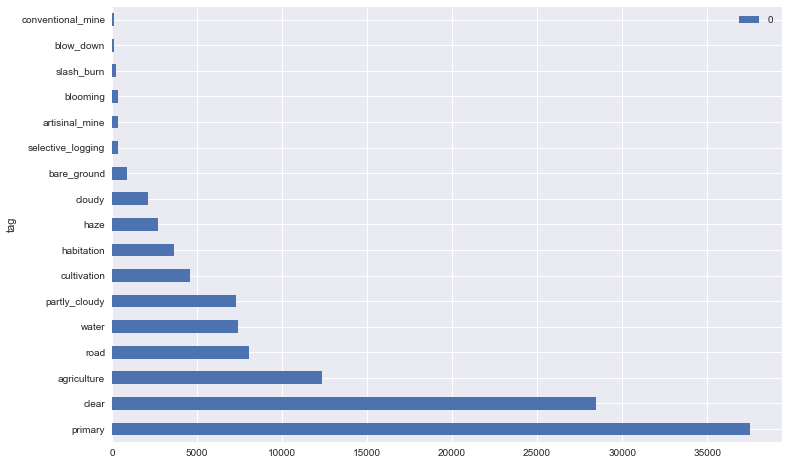

In [3]:
df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
# print(all_tags)
# example data
from collections import Counter

counts = Counter(df['tags'])
df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_counts = df_counts.rename(columns={'index':'label', 0:'count'})


print(df_counts.sort_values(by=['count'], ascending=False))
print(df_counts[df_counts ['count']< 5.0 ].count())


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

In [4]:

image_paths = sorted(os.listdir(train_path1))[0:1000]

image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

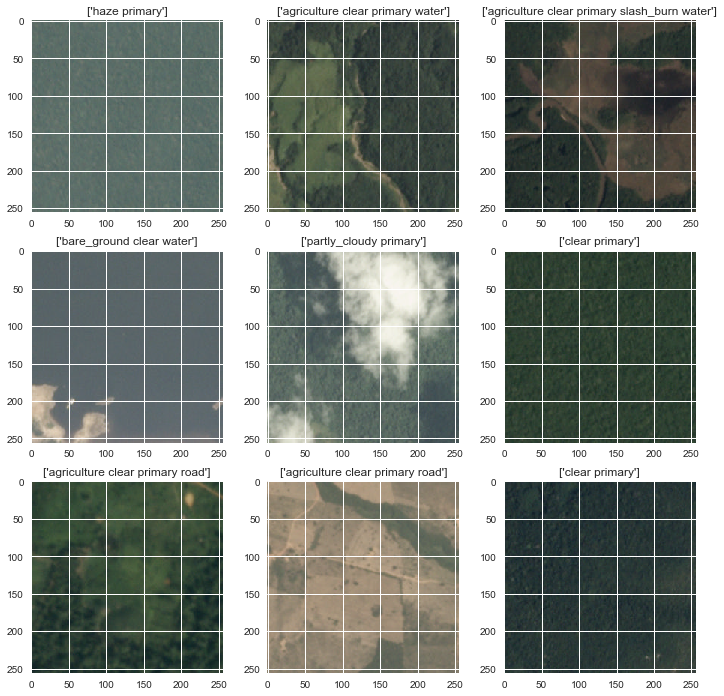

In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    path2='train_jpg/'
    plt.imshow(plt.imread(path2+str(image_paths[i])))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

In [ ]:
np.seterr(all='warn')
def veg_and_water(image_str):
    tif_img = io.imread(train_path2+image_str)
    RGB= get_rgb(tif_img, [2, 1, 0]) # RGB
    IRRG = get_rgb(tif_img, [3, 2, 1]) # NIR-R-G
    IRRB = get_rgb(tif_img, [3, 2, 0]) # NIR-R-Bs
    #this predicts likelihood of a tree being there
    veg_np = (IRRG[:, :, 0] - IRRG[:, :, 1]) / (IRRG[:, :, 0] + IRRG[:, :, 1]) # (NIR - RED) / (NIR + RED)
    #this predicts likelihood of waters
    water_np = (IRRB[:, :, 2] - IRRB[:, :, 0]) / (IRRB[:, :, 2] + IRRB[:, :, 0]) #
    return [veg_np,water_np]

# image_paths = sorted(os.listdir(train_path2))

extracted_features=[]

for i in range(len(os.listdir(train_path2))):
    extracted_features.append(veg_and_water("train_"+str(i)+".tif"))
print(extracted_features)   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


C:\Users\Elle\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


C:\Users\Elle\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
34

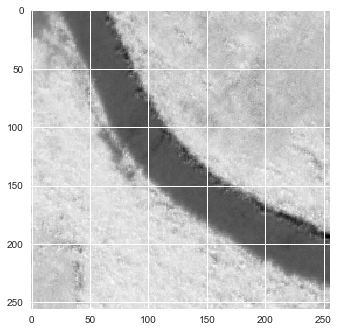

In [23]:
##show the water body works
plt.imshow(extracted_features[16363][1])


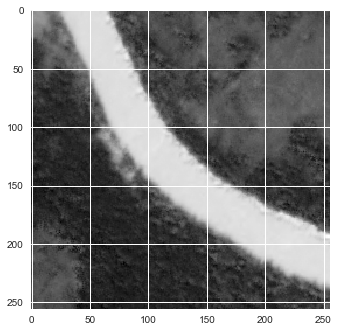

In [22]:
#### show the veg body works
plt.imshow(extracted_features[16363][0])

In [ ]:

## haze - remover - this only works on JPGs - possibly can be used to remove haze

import math
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res


def remove_haze(image):
    src = cv2.imread("train_jpg/train_40378.jpg");

    I = src.astype('float64')/255;
 
    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);

    cv2.imshow("dark",dark);
    cv2.imshow("t",t);
    cv2.imshow('I',src);
    cv2.imshow('J',J);
    cv2.imwrite("./image/J.jpg",J*255);
    cv2.waitKey();

In [ ]:
remove_haze()